In [1]:
import tarfile
from itertools import combinations

import numpy as np
import scipy.io

from ase import Atoms
import ase.io.xyz
from rascal.representations import SphericalExpansion
from rascal.utils import (ClebschGordanReal, compute_lambda_soap, 
                          spherical_expansion_reshape)

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import erf as jerf
import optax

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

ORCA_TGZ = 'QM7_B3LYP_cc-pVTZ.tgz' # https://zenodo.org/record/7048725/files/QM7_B3LYP_cc-pVTZ.tgz
HORTON_TGZ = 'QM7_B3LYP_cc-pVTZ_horton.tgz' # https://zenodo.org/record/7048725/files/QM7_B3LYP_cc-pVTZ_horton.tgz
QM7_MAT = 'qm7.mat' # http://quantum-machine.org/data/qm7.mat

ANGSTROM_TO_BOHR = 1.88973

SPECIES = (1, 6, 7, 8, 16)
SPECIES_ID = np.zeros(max(SPECIES)+1, dtype=int)
for i, z in enumerate(SPECIES):
    SPECIES_ID[z] = i
SPECIES_ID[0] = -1

SPHERICAL_EXPANSION_HYPERS_COMMON = {
    "gaussian_sigma_constant": 0.5,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    'expansion_by_species_method': 'user defined',
    'global_species': SPECIES
}

# Used for lambda-SOAP support (ongoing work). Here we are
# only interested in invariant learning, so is set to zero
L_MAX=0 

COLORS = ('grey', 'green', 'blue', 'red', 'orange')
NAMES = ('H', 'C', 'N', 'O', 'S')

LEGEND_ELEMENTS = [Patch(facecolor=color, label=name) 
                   for color, name in zip(COLORS, NAMES)]

# For initial guess of k_Z
FREE_VOLUMES = np.array([7.5344, 33.972, 25.395, 21.361, 75.479])
FREE_ALPHAS = np.array([4.5, 12, 7.4, 5.4, 19.6])

Original error:
No module named 'skcosmo'


In [2]:
# Helper functions

def pad_to_shape(array, shape, value=0):
    pad = [(0, n_max - n) for n_max, n in zip(shape, array.shape)]
    return np.pad(array, pad, constant_values=value)

def pad_to_max(arrays, value=0):
    # Takes arrays with different shapes, but same number of dimensions
    # and pads them to the size of the largest array along each axis
    shape = np.max([_.shape for _ in arrays], axis=0)
    return np.array([pad_to_shape(_, shape, value) for _ in arrays])

def zip_list_of_dicts(l):
    # Converts list of dicts to dict of lists
    return {key: [_[key] for _ in l] for key in l[0].keys()}

### Parse QM7 geometries
First, convert the molecules from QM7 dataset to ASE Atoms objects. Shift the coordinates to the origin to make rascal happy.

In [3]:
def get_atoms_from_qm7(qm7_z, qm7_xyz):
    n_atoms = sum(qm7_z > 0)
    z = qm7_z[:n_atoms]
    xyz = qm7_xyz[:n_atoms] / ANGSTROM_TO_BOHR
    xyz_min = np.min(xyz, axis=0)
    xyz_max = np.max(xyz, axis=0)
    xyz_range = xyz_max - xyz_min
    return Atoms(z, positions=xyz - xyz_min, cell=xyz_range, pbc=0)

In [4]:
qm7 = scipy.io.loadmat(QM7_MAT, squeeze_me=True)
atoms_list = [get_atoms_from_qm7(z, xyz) 
              for z, xyz in zip(qm7['Z'], qm7['R'])]
n_mols = len(atoms_list)

Now calculate the interatomic vectors, distance matrices and auxiliary tensors used to calculate interactions between Gaussian charges ($T_{00}$) in QEq model and induced dipoles ($T_{11}, T_{21}, T_{22}$) in Thole model.

In [5]:
def get_outer(a):
    # Takes a list of N 3D vectors and returns a 3Nx3N matrix 
    # of their outer products
    n = len(a)
    idx = np.triu_indices(n, 1)

    result = np.zeros((n, n, 3, 3))
    result[idx] = a[idx][:, :, None] @ a[idx][:, None, :]
    result.swapaxes(0,1)[idx] = result[idx]

    return result.swapaxes(1, 2).reshape((n * 3, n * 3))


def get_t(xyz):
    n_atoms = len(xyz)
    t01 = np.zeros((n_atoms, n_atoms))
    t11 = np.zeros((n_atoms, n_atoms * 3))
    t21 = np.zeros((n_atoms * 3, n_atoms * 3))
    t22 = np.zeros((n_atoms * 3, n_atoms * 3))

    rr_mat = xyz[:, None, :] - xyz[None, :, :]
    r_mat = np.linalg.norm(rr_mat, axis=2)

    r_inv = 1. / r_mat
    r_inv[np.diag_indices_from(r_mat)] = 0.

    r_inv1 = r_inv.repeat(3, axis=1)
    r_inv2 = r_inv1.repeat(3, axis=0)
    outer = get_outer(rr_mat)
    id2 = np.tile(np.tile(np.eye(3).T, n_atoms).T, n_atoms)

    t01 = r_inv
    t11 = -rr_mat.reshape(n_atoms, n_atoms * 3) * r_inv1 ** 3
    t21 = -id2 * r_inv2 ** 3
    t22 = 3 * outer  * r_inv2 ** 5

    return {'r_mat': r_mat, 'rr_mat': rr_mat, 
            'T01': t01, 'T11': t11, 'T21': t21, 'T22': t22}


def get_geom_data(atoms_list):
    xyz = [(atoms.positions * ANGSTROM_TO_BOHR) for atoms in atoms_list]
    aux_arrays = zip_list_of_dicts([get_t(_) for _ in xyz])
    aux_arrays_padded = {k: pad_to_max(v) for k, v in aux_arrays.items()}
    return {'xyz': pad_to_max(xyz), **aux_arrays_padded}

geom_data = get_geom_data(atoms_list)

/apps/PYTHON/3.7.4_ML/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


### Calculate SOAP feature vectors
The code supports learning equivariant properties with $\lambda$-SOAP (ongoing work), but here only invariant learning is done, so $l=0$

In [6]:
L_PERM = [[0],
          [2, 0, 1],
          [2, 3, 1, 4, 0]]

def get_soap(spex_feats, cg, l):
    n_mols = spex_feats.shape[0]
    lX = compute_lambda_soap(spex_feats, cg, l, 0)
    lX = np.moveaxis(lX.reshape((n_mols, -1, l*2 + 1)), 2, 1)[:, L_PERM[l]]
    lnorm = np.linalg.norm(lX, axis=(1,2))
    return lX / lnorm[:, None, None]


def get_atoms_soap(atoms, cg, hypers):
    spex = SphericalExpansion(**hypers)
    spex_feats_flat = spex.transform(atoms).get_features(spex)
    spex_feats = spherical_expansion_reshape(spex_feats_flat, **hypers)
    return [get_soap(spex_feats, cg, i) for i in range(L_MAX+1)]


def get_atoms_list_soap(atoms_list, hypers):
    cg = ClebschGordanReal(lmax=hypers["max_angular"])
    soap = zip(*[get_atoms_soap(atoms, cg, hypers) 
                 for atoms in atoms_list])
    return list(map(pad_to_max, soap))


hypers = {"interaction_cutoff": 3.,
          "max_radial": 4,
          "max_angular": 4,
          **SPHERICAL_EXPANSION_HYPERS_COMMON}

soap_qm7 = get_atoms_list_soap(atoms_list, hypers)

### Select representative feature vectors with IVM
The basis atomic environments are only chosen from training set molecules, so define training/test set masks first. Four molecules with distorted structures were removed (see section S1 in SI).

In [7]:
train_mask = np.arange(n_mols) % 5 < 4
test_mask = np.arange(n_mols) % 5 == 4

# Remove outliers
train_mask[np.array([3998, 2160, 4116])] = False
test_mask[2154] = False

Pick the feature vectors of the training set

In [8]:
soap_qm7_train = [_[train_mask] for _ in soap_qm7]

Also, create an array of (molecule_id, atom_id) pairs (as in the full dataset) for the training set. This is needed to be able to locate atoms/molecules in the original dataset that were picked by IVM.

In [9]:
max_atoms = qm7['Z'].shape[1]
atom_ids = np.moveaxis(np.mgrid[:n_mols,:max_atoms], 0, 2)
atom_ids_train = atom_ids[train_mask]

Do IVM (may take a couple of minutes)

In [10]:
def norm_lsoap_kernel(a, b):
    # a: NA x L*2+1 x NLSOAP
    # b: NB x L*2+1 x NLSOAP
    # result: NA x L*2+1 x NB x L*2+1
    return np.tensordot(a, b, (2, 2))


def sq_soap_kernel(a, b):
    return norm_lsoap_kernel(a, b).reshape((len(a), len(b))) ** 2


def ivm(soap_0, thr=0.02, n_max=None):
    n_samples = len(soap_0)
    selected = [0]
    n_max = min(n_max or n_samples, n_samples)
    
    k_old = None
    
    for i in range(1, n_max):
        pending = np.delete(range(n_samples), selected)
        soap_sel, soap_pen = soap_0[selected], soap_0[pending]
        K_sel = sq_soap_kernel(soap_sel, soap_sel)
        K_sel_inv = np.linalg.inv(K_sel)
        
        if k_old is None:
            k = sq_soap_kernel(soap_pen, soap_sel)
        else:
            k_new = sq_soap_kernel(soap_pen, soap_sel[-1:])
            k = np.hstack([k_old, k_new])
        
        var = np.ones(len(pending)) - np.sum(k @ K_sel_inv * k, axis=1)
        
        max_var = np.max(var)
        if max_var < thr:
            break
        selected.append(pending[np.argmax(var)])
        k_old = np.delete(k, np.argmax(var), axis=0)
    return selected


def get_ivm_data_allz(soap_allz, thr):
    # soap_all_z: NSP * NL * NZ x 2L+1 x NLSOAP
    # result: NSP * NIVMZ
    return [ivm(soap_z[0], thr) for soap_z in soap_allz]


def get_ivm_data(soap_mols, z_mols, atom_ids, species, thr):
    # soap_mols: NL * NMOLS x ATOMS_MAX x 2L+1 x NLSOAP
    # z_mols: NMOLS x ATOMS_MAX
    
    soap_allz = [[soap_mols[l][z_mols == z] for l in range(L_MAX+1)] 
                 for z in species]
    ivm_idx = get_ivm_data_allz(soap_allz, thr)
    
    ivm_mol_atom_ids = [atom_ids[z_mols == z][z_ivm_idx]
                        for z, z_ivm_idx in zip(species, ivm_idx)]
    ivm_mol_atom_ids_padded = pad_to_max(ivm_mol_atom_ids, value=-1)
    
    soap_ivm_allz = [[soap_z[l][ivm_idx_z] for l in range(L_MAX+1)] 
                     for soap_z, ivm_idx_z in zip(soap_allz, ivm_idx)]
    
    return {'ivm_mol_atom_ids': ivm_mol_atom_ids_padded,
            'soap_ivm_allz': soap_ivm_allz}

ivm_data = get_ivm_data(soap_qm7_train, qm7['Z'][train_mask], 
                        atom_ids_train, SPECIES, 0.05)

Calculate the kernels between the basis vectors and the full dataset

In [11]:
def get_K_mols_ref(K_ivm_allz, z_mols, species):
    # K_ivm_allz: NSP * NL * NZ x 2L+1 x NIVMZ x 2L+1
    # z_mols: NMOLS x ATOMS_MAX
    # result: NL * NMOLS x ATOMS_MAX x 2L+1 x MAXIVMZ x 2L+1
    ivm_max = max([K_ivm_z[0].shape[2] for K_ivm_z in K_ivm_allz])
    result = [np.zeros((*z_mols.shape, l*2+1, ivm_max, l*2+1)) 
              for l in range(L_MAX+1)]
    for l, result_l in enumerate(result):
        for z, K_ivm_z in zip(species, K_ivm_allz):
            pad = ivm_max - K_ivm_z[l].shape[2]
            result_l[z_mols == z] = np.pad(K_ivm_z[l], 
                                           ((0, 0), (0, 0), (0, pad), (0, 0)))
        
    return result


def get_kernels(soap_mols, z_mols, soap_ivm_allz, species):
    # soap_mols: NL * NMOLS x ATOMS_MAX x 2L+1 x NLSOAP
    # soap_ivm_allz: NSP * NL * NZ x 2L+1 x NLSOAP
    soap_allz = [[soap_mols[l][z_mols == z] for l in range(L_MAX+1)] 
                 for z in species]

    K_ref_ref = [[norm_lsoap_kernel(soap_ivm_z[l], soap_ivm_z[l]) 
                  for soap_ivm_z in soap_ivm_allz] 
                 for l in range(L_MAX+1)]
    K_ref_ref_padded = [pad_to_max(_) for _ in K_ref_ref]
    
    K_ivm_allz = [[norm_lsoap_kernel(soap_z[l], soap_ivm_z[l]) 
                   for l in range(L_MAX+1)]
                  for soap_z, soap_ivm_z in zip(soap_allz, soap_ivm_allz)]
    K_mols_ref = get_K_mols_ref(K_ivm_allz, z_mols, species)
    
    # Squeeze, since not doing lambda-SOAP
    return {'K_ref_ref': K_ref_ref_padded[0].squeeze(),
            'K_mols_ref': K_mols_ref[0].squeeze()}


ivm_kernels = get_kernels(soap_qm7, qm7['Z'], ivm_data['soap_ivm_allz'], 
                          SPECIES)

### Precalculate coefficients for GPR
Precalculate the coefficients that are multiplied by reference values to get the predictions. Same coefficients are used to predict $s$ values from $s_{ref}$ learned with sparse GPR (see below) and $\chi$ values from $\chi_{ref}$ obtained by fitting the $q$ predicted with QEq to MBIS charges (see below).

In [12]:
SIGMA = 1E-3

def get_c(K_ref_ref, K_mols_ref, zid, sigma):
    n_z, n_ivm = K_ref_ref.shape[:2]
    K_ref_ref_inv = np.linalg.inv(K_ref_ref**2 + 
                                  sigma ** 2 * np.identity(n_ivm))
    n_mols, max_atoms = zid.shape
    
    c = np.zeros((n_mols, max_atoms, n_ivm))
    for z in range(np.max(zid) + 1):
        K_mols_ref_z = K_mols_ref[zid == z].squeeze() ** 2
        c_z = K_mols_ref_z @ K_ref_ref_inv[z]
        c[zid == z] = c_z
        
    return c

zid = SPECIES_ID[np.array(qm7['Z'], dtype=int)]
c = get_c(ivm_kernels['K_ref_ref'], ivm_kernels['K_mols_ref'], zid, SIGMA)

### Read reference QM data
`ORCA_TGZ` is the tarball with outputs of single point B3LYP/cc-PVTZ calculations with ORCA for the molecules in QM7 dataset. Extract them one by one and read the polarizability section.

In [13]:
def seek_to(f, value):
    while next(f) != value:
        pass


def skip(f, n):
    for _ in range(n):
        next(f)
        

def parse_orca_out(f):
    seek_to(f, b'THE POLARIZABILITY TENSOR\n')
    skip(f, 3)
    alpha = [list(map(float, next(f).split())) for _ in range(3)]
    return np.array(alpha)


def get_alpha_by_id(id_, orca_tgz):
    return parse_orca_out(orca_tgz.extractfile(f'{id_}.out'))

orca_tgz = tarfile.open(ORCA_TGZ, mode='r:gz')
alpha = np.array([get_alpha_by_id(i + 1, orca_tgz) for i in range(n_mols)])

`HORTON_TGZ` contains the outputs of MBIS analysis over the B3LYP/cc-PVTZ densities done with Horton 2.0.3. Read valence widths $s$, core charges $q_{core}$, full charges $q$ and volumes $v$. Since the tarball is heavy, read the files in the order they are stored to make it faster.

In [14]:
import h5py
import io

def parse_horton_out(f):
    q_shift = np.mean(f['cartesian_multipoles'][:,0])
    return {'s': f['valence_widths'][:],
            'q_core': f['core_charges'][:],
            'q': f['cartesian_multipoles'][:,0] - q_shift,
            'v': f['radial_moments'][:,3]}


def get_horton_data_by_file(t, tgz):
    f = io.BytesIO(horton_tgz.extractfile(t).read())
    return parse_horton_out(h5py.File(f, 'r'))

horton_tgz = tarfile.open(HORTON_TGZ, mode='r|gz')
horton_dicts = [None for _ in range(n_mols)]
for t in horton_tgz:
    i = int(t.name.split('.')[0]) - 1
    horton_dicts[i] = get_horton_data_by_file(t, horton_tgz)

In [15]:
# Store each MBIS property as an np.array with shape (n_mols, n_atoms)
# Since molecules have different n_mols, pad with zeros when needed
horton_data = {k: pad_to_max(v) for k, v 
               in zip_list_of_dicts(horton_dicts).items()}

Combine all the data and split into test/training subsets

In [16]:
def apply_mask(data, mask):
    return {k: v[mask] for k, v in data.items()}


full_data = {'zid': zid, 
             'atoms_mask': qm7['Z'] > 0,
             'K_mols_ref': ivm_kernels['K_mols_ref'],
             **geom_data, 
             **horton_data,
             'alpha': alpha,
             'c': c}

gpr_data = {'ivm_mol_atom_ids': ivm_data['ivm_mol_atom_ids'],
            'K_ref_ref': ivm_kernels['K_ref_ref']}

train_data = apply_mask(full_data, train_mask)
test_data = apply_mask(full_data, test_mask)

### Learn embedding model parameters
First, "learn" $q_{core}$ by taking per-element averages of MBIS values over the training set

In [17]:
def mean_by_z(arr, zid):
    return np.array([np.mean(arr[zid==i]) for i in range(np.max(zid) + 1)])

q_core = mean_by_z(train_data['q_core'], train_data['zid'])

Now learn $s_{ref}$ with modified sparse GPR (see SI, section S2). Learning is fast, so is done on CPU for simplicity.

In [18]:
def sparse_fit(y, Kmm, Knm, sigma):
    Kmms = Kmm + sigma ** 2 * np.identity(len(Kmm))
    A = np.linalg.inv(Kmms) @ Knm.T
    B = np.linalg.pinv(A.T)
    
    By = B @ y
    B1 = np.sum(B, axis=1)
    y0 = np.sum(By) / np.sum(B1)
    y_ref = By - y0 * B1
    
    return y_ref + y0


def fit_s_by_z(data, gpr_data, sigma, z):
    n_ref = sum(gpr_data['ivm_mol_atom_ids'][z][:,0] > -1)
    Kmm = gpr_data['K_ref_ref'][z, :n_ref, :n_ref] ** 2
    Knm = data['K_mols_ref'][data['zid'] == z, :n_ref] ** 2
    return sparse_fit(data['s'][data['zid'] == z], Kmm, Knm, sigma)

s_ref = pad_to_max([fit_s_by_z(train_data, gpr_data, 1E-3, z) 
                    for z in range(len(SPECIES))])

Learn $\chi_{ref}$ and $a_{QEq}$ for QEq model with least squares fitting to MBIS charges. This time learning is done on GPU, so the data has to be moved there.

In [19]:
def to_jax(arrays_dict):
    return {k: jnp.array(v) for k, v in arrays_dict.items()}

train_data_jax = to_jax(train_data)
test_data_jax = to_jax(test_data)

Combine necessary data that is not vectorized nor used for back-proparation.

In [20]:
ref_mask = gpr_data['ivm_mol_atom_ids'][:,:,0] > -1

const = {'ref_mask': ref_mask,
         'n_ref': np.sum(ref_mask, axis=1),
         'q_core': q_core,
         's_ref': s_ref}

const_jax = to_jax(const)

Precalculate predicted $s$ values and store them in data dictionaries. First, predict $s$ for a single molecule, then vectorise using JAX `vmap` feature. The same approach is used for all subroutines below.

In [21]:
def _mask(x, mask):
    return jnp.where(mask, x, 0.)


def get_gpr_value(c, y_ref, zid, atoms_mask, const):
    y_ref = _mask(y_ref, const['ref_mask'])
    y0 = jnp.sum(y_ref, axis=1) / const['n_ref']
    mol_y0 = _mask(y0[zid], atoms_mask)
    mol_y_ref = _mask(y_ref[zid], atoms_mask[:, None])
    mol_y_ref_norm = mol_y_ref - mol_y0[:, None]
    return (jnp.sum(c * mol_y_ref_norm, axis=1) + mol_y0).flatten()


def get_s(data, const):
    return get_gpr_value(data['c'], const['s_ref'], data['zid'], 
                         data['atoms_mask'], const)

get_s_mols = vmap(get_s, in_axes=(0, None))

train_data_jax['s_gpr'] = get_s_mols(train_data_jax, const_jax)
test_data_jax['s_gpr'] = get_s_mols(test_data_jax, const_jax)

Now fit $a_{QEq}$ and $\chi_{ref}$. The loss function is RMSE for the predicted charges.

In [22]:
def get_T0_gaussian(t01, r, s_mat):
    s_inv = _mask(1. / s_mat, s_mat > 0.)
    return t01 * jerf(r * s_inv / jnp.sqrt(2))


def get_A_QEq(data, s):
    zid = data['zid']
    atoms_mask = data['atoms_mask']
    atoms_mask_mat = atoms_mask[:, None] * atoms_mask[None, :]
    
    s2 = s ** 2
    
    s_mat = _mask(jnp.sqrt(s2[:, None] + s2[None, :]), atoms_mask_mat)
    A_nodiag = get_T0_gaussian(data['T01'], data['r_mat'], s_mat)
    
    s_inv = _mask(1. / s, atoms_mask)
    diag = s_inv / jnp.sqrt(jnp.pi)
    
    diag = diag - atoms_mask + 1 # 1's on diag for dummy atoms
    
    A = A_nodiag.at[jnp.diag_indices_from(A_nodiag)].set(diag)
    ones = atoms_mask[:, None]
    return jnp.block([[A, ones], [ones.T, 0.]])


def get_q(data, params, const):
    s_gauss = _mask(data['s_gpr'] * params['a_QEq'], data['atoms_mask'])
    A_QEq = get_A_QEq(data, s_gauss)
    chi = get_gpr_value(data['c'], params['chi_ref'], data['zid'], 
                        data['atoms_mask'], const)
    b = jnp.hstack([-chi,  0])
    return jnp.linalg.solve(A_QEq, b)[:-1]

get_q_mols = vmap(get_q, in_axes=(0, None, None))


def get_rms(x, n):
    return jnp.linalg.norm(x) / jnp.sqrt(n)


def q_loss(data, params, const):
    q = get_q_mols(data, params, const)
    n_atoms = np.sum(data['atoms_mask'])
    return get_rms(q - data['q'], n_atoms)


q_loss_and_grad = jit(jax.value_and_grad(q_loss, 1))

In [23]:
n_z, max_ref = gpr_data['K_ref_ref'].shape[:2]
params_QEq = to_jax({'a_QEq': jnp.array(2.),
                     'chi_ref': jnp.zeros((n_z, max_ref))})

In [24]:
def print_loss(epoch, loss_f, mols_data, params, const):
    loss_ = loss_f(mols_data, params, const)
    print(f'{epoch:4d} Loss: {loss_:9.3e}')
    
LEARNING_RATE = 0.002

loss_f = q_loss
loss_f_and_grad = q_loss_and_grad

opt = optax.adam(LEARNING_RATE)
opt_state = opt.init(params_QEq)

for epoch in range(1000):
    loss_, grad = loss_f_and_grad(train_data_jax, params_QEq, const_jax)
    updates, opt_state = opt.update(grad, opt_state)
    params_QEq = optax.apply_updates(params_QEq, updates)
        
    if epoch % 100 == 0:
        print_loss(epoch, q_loss, train_data_jax, params_QEq, const_jax)

print_loss(epoch, q_loss, train_data_jax, params_QEq, const_jax)

   0 Loss: 2.630e-01
 100 Loss: 2.797e-02
 200 Loss: 2.108e-02
 300 Loss: 2.055e-02
 400 Loss: 2.034e-02
 500 Loss: 2.021e-02
 600 Loss: 2.012e-02
 700 Loss: 2.005e-02
 800 Loss: 2.001e-02
 900 Loss: 1.998e-02
 999 Loss: 1.996e-02


In [25]:
const_jax.update(params_QEq)
train_data_jax['q_QEq'] = get_q_mols(train_data_jax, params_QEq, const_jax)
test_data_jax['q_QEq'] = get_q_mols(test_data_jax, params_QEq, const_jax)

Now fit $a_{Thole}$ and $k_Z$. The loss function is MSE for the predicted molecular dipolar polarizabilities.

In [26]:
def block_sum(x):
    ax1 = x.shape[0] // 3
    ax2 = x.shape[1] // 3
    return jnp.sum(x.reshape((ax1, 3, ax2, 3)), axis=(0, 2))


def lambda3(au3):
    return 1 - jnp.exp(-au3)


def lambda5(au3):
    return 1 - (1 + au3) * jnp.exp(-au3)


def get_T2_thole(tr21, tr22, au3):
    return lambda3(au3) * tr21 + lambda5(au3) * tr22


def get_A_Thole(data, params, const):
    zid = data['zid']
    atoms_mask = data['atoms_mask']
    atoms_mask_mat = atoms_mask[:, None] * atoms_mask[None, :]    
    q_core = const['q_core'][zid]
    N = q_core - data['q_QEq']
    v = 60 * N * data['s_gpr'] ** 3
    
    alpha = _mask(params['k_Z'][zid] * v, atoms_mask)
    
    alphap = _mask(alpha * params['a_Thole'], atoms_mask)
    alphap_mat = _mask(alphap[:, None] * alphap[None, :], atoms_mask_mat)
    
    au3 = _mask(data['r_mat'] ** 3 / jnp.sqrt(alphap_mat), atoms_mask_mat)
    au31 = au3.repeat(3, axis=1)
    au32 = au31.repeat(3, axis=0)
    A_nodiag = - get_T2_thole(data['T21'], data['T22'], au32)
    
    latoms_mask = atoms_mask.repeat(3)
    A_diag = _mask(1. / alpha.repeat(3), latoms_mask)
    A_diag = A_diag - latoms_mask + 1 # 1's on diag for dummy atoms
    return A_nodiag.at[jnp.diag_indices_from(A_nodiag)].set(A_diag)


def get_alpha(data, params, const):
    A_Thole = get_A_Thole(data, params, const)
    Ainv = jnp.linalg.inv(A_Thole)
    atoms_mask = data['atoms_mask']
    atoms_mask_mat = atoms_mask[:, None] * atoms_mask[None, :]
    latoms_mask_mat = atoms_mask_mat.repeat(3, axis=1).repeat(3, axis=0)
    return block_sum(_mask(Ainv, latoms_mask_mat))

get_alpha_mols = vmap(get_alpha, in_axes=(0, None, None))


def alpha_loss(data, params, const):
    alpha = get_alpha_mols(data, params, const)
    n_mols = len(data['zid'])
    return get_rms((alpha - data['alpha']), n_mols * 9)

alpha_loss_and_grad = jit(jax.value_and_grad(alpha_loss, 1))

In [27]:
params_Thole = to_jax({'a_Thole': 2.,
                       'k_Z': FREE_ALPHAS / FREE_VOLUMES})

In [28]:
LEARNING_RATE = 0.001

loss_f = alpha_loss
loss_f_and_grad = alpha_loss_and_grad

opt = optax.adam(LEARNING_RATE)
opt_state = opt.init(params_Thole)

for epoch in range(1000):
    loss_, grad = loss_f_and_grad(train_data_jax, params_Thole, const_jax)
    updates, opt_state = opt.update(grad, opt_state)
    params_Thole = optax.apply_updates(params_Thole, updates)
        
    if epoch % 100 == 0:
        print_loss(epoch, loss_f, train_data_jax, params_Thole, const_jax)

print_loss(epoch, loss_f, train_data_jax, params_Thole, const_jax)

   0 Loss: 4.671e+00
 100 Loss: 4.252e+00
 200 Loss: 4.207e+00
 300 Loss: 4.139e+00
 400 Loss: 4.008e+00
 500 Loss: 3.586e+00
 600 Loss: 2.984e+00
 700 Loss: 2.983e+00
 800 Loss: 2.983e+00
 900 Loss: 2.983e+00
 999 Loss: 2.983e+00


In [29]:
const_jax.update(params_Thole)
train_data_jax['alpha_Thole'] = get_alpha_mols(train_data_jax, params_Thole, const_jax)
test_data_jax['alpha_Thole'] = get_alpha_mols(test_data_jax, params_Thole, const_jax)

Write fitted parameters and reference feature vectors

In [30]:
result = {k: np.array(v) for k, v in const_jax.items()}
del result['ref_mask']

ref_soap = pad_to_max([_[0].squeeze() for _ in ivm_data['soap_ivm_allz']])
result['ref_soap'] = ref_soap

scipy.io.savemat('mlmm.mat', result)

### Generate figures

In [31]:
plt.rc('font', size=20)
def plot(x, y, rmsd, units, x_label, y_label, title, c=None, ticks=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.scatter(x, y, s=10.0, marker='.', lw=0.2, c=c)
    min_x = np.min([x, y])
    max_x = np.max([x, y])
    if ticks is not None:
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
    ax.plot([min_x, max_x], [min_x, max_x], c='black', zorder=0)
    ax.text(max_x, min_x, f'RMSE: ${rmsd:6.3f}$ {units}', ha='right')
    return ax

In [32]:
train_atoms_mask = train_data_jax['atoms_mask'].flatten() == 1
train_n_atoms = sum(train_atoms_mask)
train_n_mols = len(train_data_jax['zid'])
train_color_id = train_data_jax['zid'].flatten()[train_atoms_mask]
train_colors = [COLORS[_] for _ in train_color_id]

test_atoms_mask = test_data_jax['atoms_mask'].flatten() == 1
test_n_atoms = sum(test_atoms_mask)
test_n_mols = len(test_data_jax['zid'])
test_color_id = test_data_jax['zid'].flatten()[test_atoms_mask]
test_colors = [COLORS[_] for _ in test_color_id]

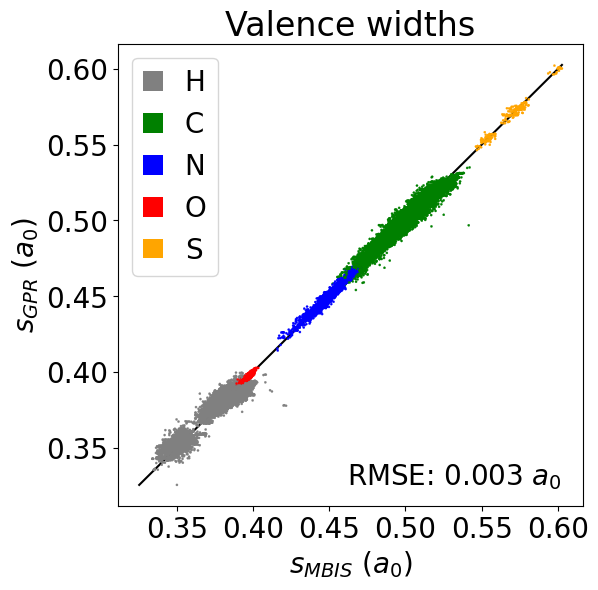

In [33]:
s = np.array(train_data_jax['s'])
s_calc = np.array(train_data_jax['s_gpr'])
rmsd = get_rms(s - s_calc, train_n_atoms)

x = s.flatten()[train_atoms_mask]
y = s_calc.flatten()[train_atoms_mask]

ax = plot(x, y, rmsd, '$a_0$', '$s_{MBIS}\ (a_0)$', 
          '$s_{GPR}\ (a_0)$', 'Valence widths', train_colors, 
          np.arange(0.35, 0.65, 0.05))
ax.legend(handles=LEGEND_ELEMENTS, loc='upper left', handlelength=0.7)
plt.show()

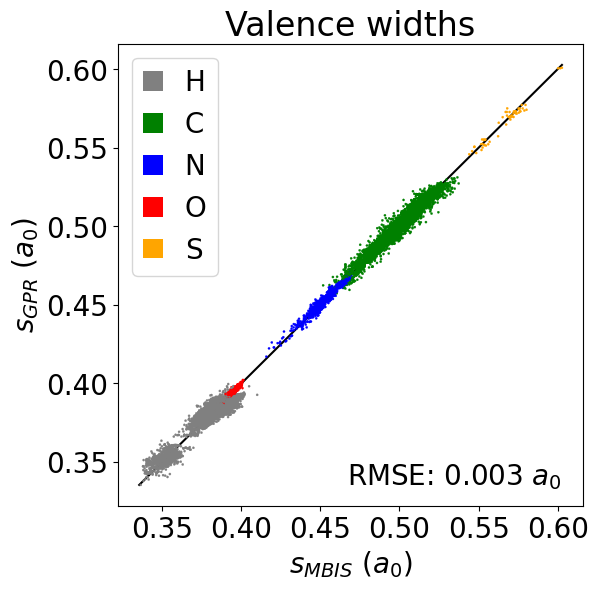

In [34]:
s = np.array(test_data_jax['s'])
s_calc = np.array(test_data_jax['s_gpr'])
rmsd = get_rms(s - s_calc, test_n_atoms)

x = s.flatten()[test_atoms_mask]
y = s_calc.flatten()[test_atoms_mask]

ax = plot(x, y, rmsd, '$a_0$', '$s_{MBIS}\ (a_0)$', 
          '$s_{GPR}\ (a_0)$', 'Valence widths', test_colors, 
          np.arange(0.35, 0.65, 0.05))
ax.legend(handles=LEGEND_ELEMENTS, loc='upper left', handlelength=0.7)
plt.show()

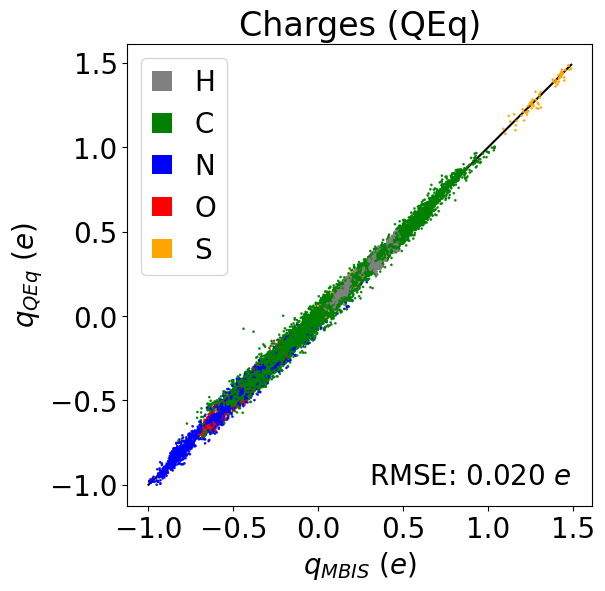

In [35]:
q = np.array(train_data_jax['q'])
q_calc = np.array(train_data_jax['q_QEq'])
rmsd = get_rms(q - q_calc, train_n_atoms)

x = q.flatten()[train_atoms_mask]
y = q_calc.flatten()[train_atoms_mask]

ax = plot(x, y, rmsd, '$e$', '$q_{MBIS}\ (e)$', 
          '$q_{QEq}\ (e)$', 'Charges (QEq)', train_colors, np.arange(-1, 1.6, 0.5))
ax.legend(handles=LEGEND_ELEMENTS, loc='upper left', handlelength=0.7)
plt.show()

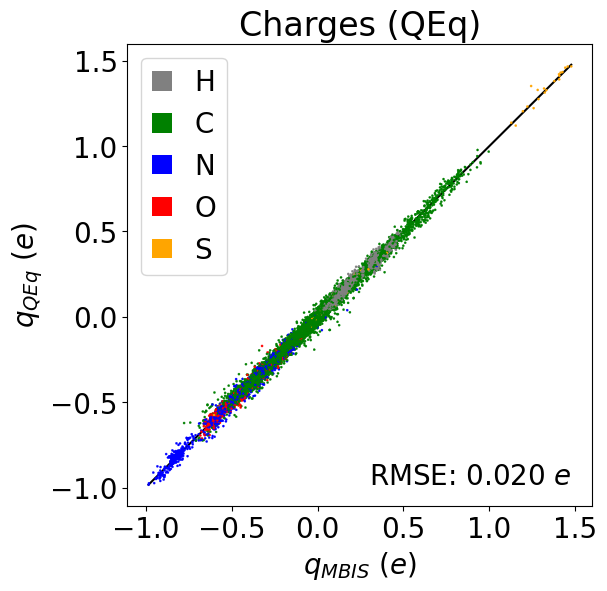

In [36]:
q = np.array(test_data_jax['q'])
q_calc = np.array(test_data_jax['q_QEq'])
rmsd = get_rms(q - q_calc, test_n_atoms)

x = q.flatten()[test_atoms_mask]
y = q_calc.flatten()[test_atoms_mask]

ax = plot(x, y, rmsd, '$e$', '$q_{MBIS}\ (e)$', 
          '$q_{QEq}\ (e)$', 'Charges (QEq)', test_colors, np.arange(-1, 1.6, 0.5))
ax.legend(handles=LEGEND_ELEMENTS, loc='upper left', handlelength=0.7)
plt.show()

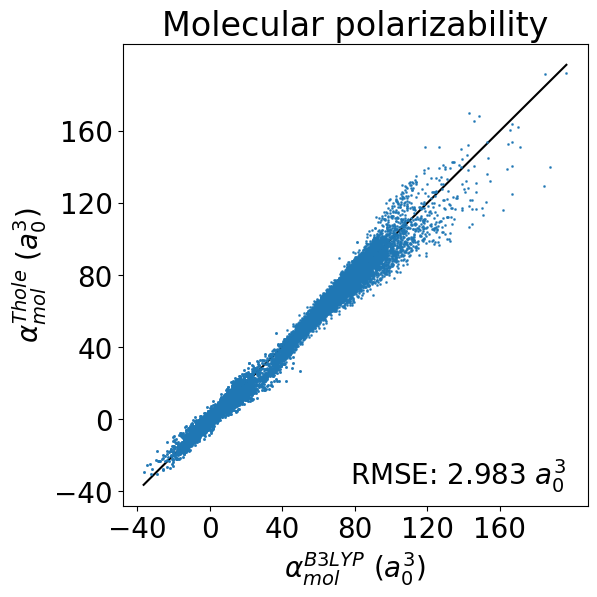

In [37]:
alpha = np.array(train_data_jax['alpha'])
alpha_calc = np.array(train_data_jax['alpha_Thole'])
rmsd = get_rms(alpha - alpha_calc, train_n_mols * 9)

x = alpha.flatten()
y = alpha_calc.flatten()

plot(x, y, rmsd, '$a_0^3$', '$\\alpha_{mol}^{B3LYP}\ (a_0^3)$', 
     '$\\alpha_{mol}^{Thole}\ (a_0^3)$', 'Molecular polarizability', 
     None, np.arange(-40, 170, 40))
plt.show()

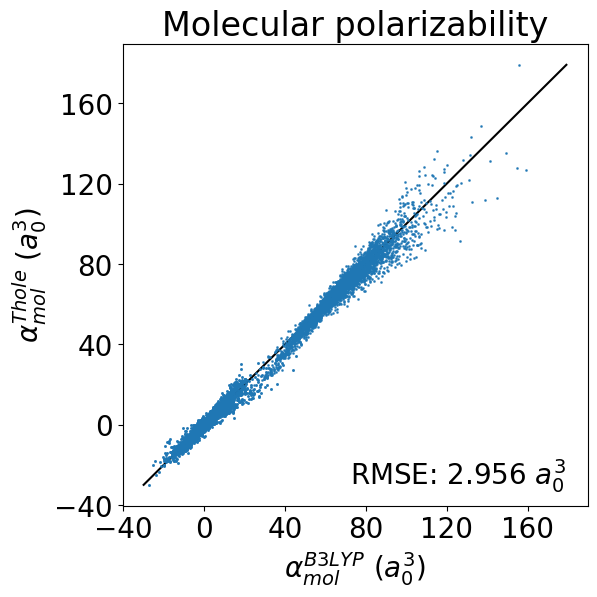

In [38]:
alpha = np.array(test_data_jax['alpha'])
alpha_calc = np.array(test_data_jax['alpha_Thole'])
rmsd = get_rms(alpha - alpha_calc, test_n_mols * 9)

x = alpha.flatten()
y = alpha_calc.flatten()

plot(x, y, rmsd, '$a_0^3$', '$\\alpha_{mol}^{B3LYP}\ (a_0^3)$', 
     '$\\alpha_{mol}^{Thole}\ (a_0^3)$', 'Molecular polarizability', 
     None, np.arange(-40, 170, 40))
plt.show()